In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulate_euler import simulate

In [2]:
y = lambda t, A=1, omega=0.04: A * np.sin(omega * t) 
r = np.tanh

In [3]:
class EchoState:
    N = 500
    g = 1.5
    dt = 0.1
    Tmax = 1000
    
    def __init__(self):
        self.J = np.random.normal(0, self.g/np.sqrt(self.N), size=(self.N, self.N))
        self.w_fb = np.random.normal(size=self.N)
        self.taxis = np.arange(0, self.Tmax, self.dt)
        
    def open_loop_train(self):
        x0 = np.random.normal(0, 0.1, size=self.N)
        Y = y(self.taxis)
        y_iter = iter(Y)
        
        x_dot = lambda x: -x + self.J.dot(r(x)) + self.w_fb.dot(next(y_iter))
        X = simulate(x_dot, x0, self.dt, self.Tmax)
        
        R = r(X)
        self.w_out = np.linalg.pinv(R).dot(Y)
        
        return X, Y

In [4]:
es = EchoState()
X, Y = es.open_loop_train()
R = r(X)
Z = R.dot(es.w_out)

## Echo State (without noise)

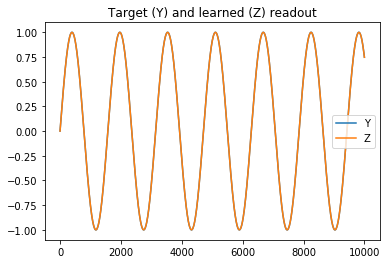

In [5]:
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.legend()
plt.title("Target (Y) and learned (Z) readout")
plt.show()

In [6]:
def plot_neurons(neurons):
    neurons_count = neurons.shape[1]
    fig = plt.figure(figsize=(4, 3*neurons_count))
    for i in range(neurons_count):
        ax = plt.subplot(neurons_count, 1, i+1)
        ax.plot(neurons[:, i])
        ax.set_title(f"Neuron {i+1}")
    plt.tight_layout()
    plt.show()

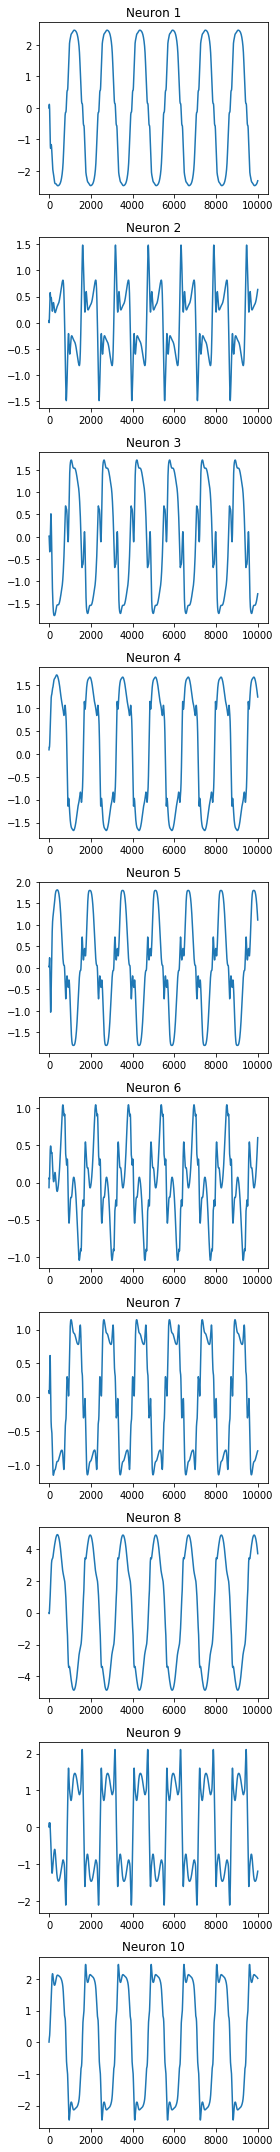

In [7]:
plot_neurons(X[:, :10])

In [8]:
def random_test(net):
    x_dot_closed = lambda x: -x + (net.J + net.w_fb[:, None] @ net.w_out[None, :]).dot(r(x))
    x0 = np.random.normal(0, 0.1, size=net.N)
    X = simulate(x_dot_closed, x0, net.dt, net.Tmax)
    R = r(X)
    Z = R.dot(net.w_out)
    return Z

In [9]:
def multiple_random_tests(net, count):
    return [random_test(net) for i in range(count)]

In [10]:
def plot_test(net, Y):
    fig = plt.figure(figsize=(4, 3*10))
    tests_count = 5
    tests = multiple_random_tests(net, tests_count)
    for i, t in enumerate(tests):
        ax = plt.subplot(tests_count+1, 1, i+1)
        ax.plot(t)
        ax.set_title(f'run {i+1}')
    ax = plt.subplot(tests_count+1, 1, tests_count+1)
    ax.plot(Y)
    ax.set_title('target')
    
    return plt

<module 'matplotlib.pyplot' from '/Users/hkariti/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

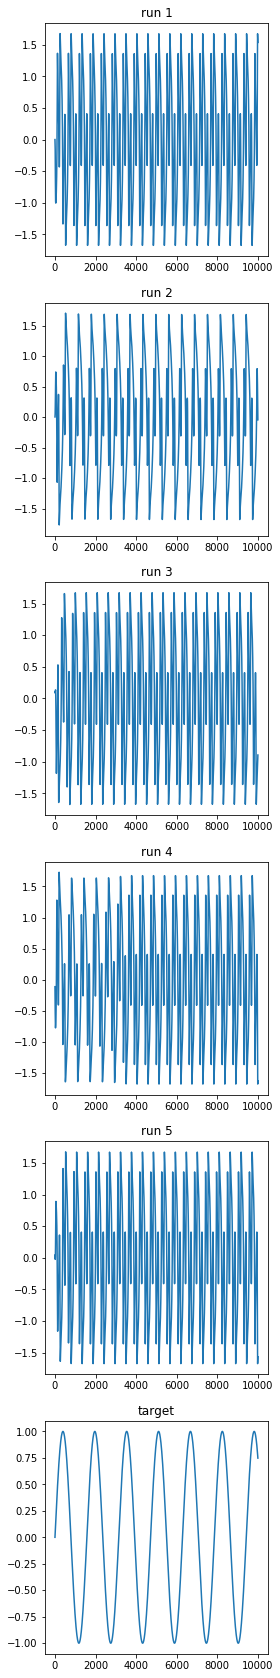

In [11]:
plot_test(es, Y)

## Echo State (with noise)

In [12]:
def open_loop_train_noisy(es):
    A_noise = 0.2
    x0 = np.random.normal(0, 0.1, size=es.N)
    Y = y(es.taxis)
    Epsilon = np.random.normal(scale=A_noise/np.sqrt(es.dt), size=es.taxis.size)
    y_iter = iter(Y)
    ep_t = iter(Epsilon)
    
    x_dot = lambda x: -x + es.J.dot(r(x)) + es.w_fb * (next(y_iter) + next(ep_t))
    X = simulate(x_dot, x0, es.dt, es.Tmax)
    R = r(X)
    es.w_out = np.linalg.pinv(R).dot(Y)
    
    return X, Y

In [13]:
es_noisy = EchoState()
X, Y = open_loop_train_noisy(es_noisy)

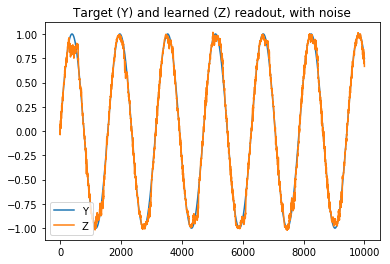

In [14]:
R = r(X)
Z = R.dot(es_noisy.w_out)
plt.plot(Y, label='Y')
plt.plot(Z, label='Z')
plt.legend()
plt.title("Target (Y) and learned (Z) readout, with noise")
plt.show()

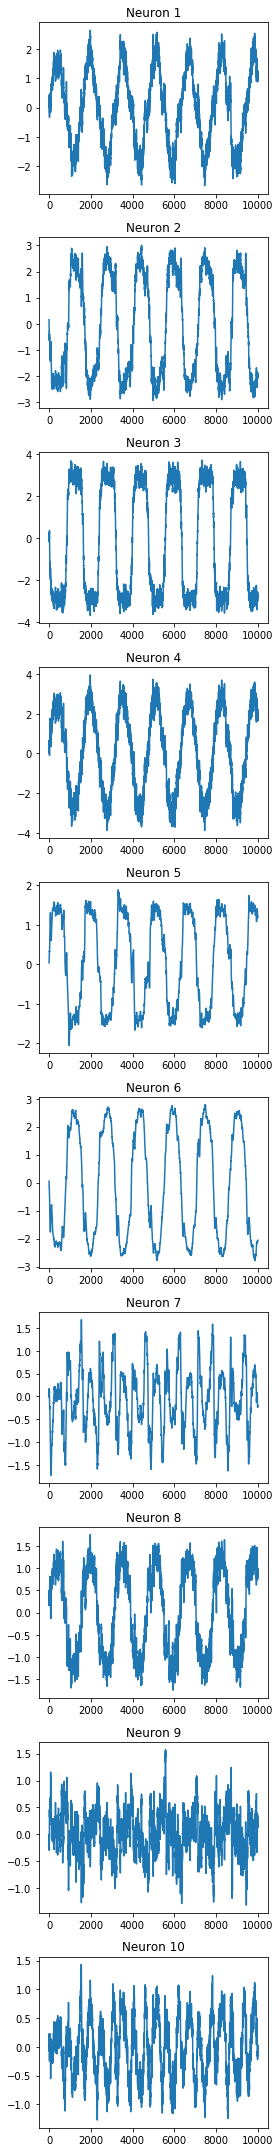

In [15]:
plot_neurons(X[:, :10])

<module 'matplotlib.pyplot' from '/Users/hkariti/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

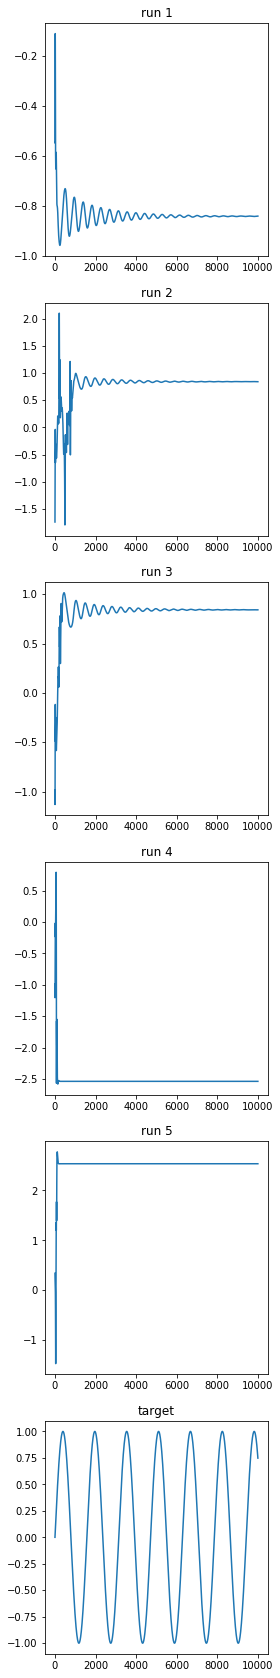

In [16]:
plot_test(es_noisy, Y)

## Force Learning

In [17]:
class Force:
    N = 500
    g = 1.5
    dt = 0.1
    Tmax = 1000
    
    def __init__(self):
        self.J = np.random.normal(0, self.g/np.sqrt(self.N), size=(self.N, self.N))
        self.w_fb = np.random.normal(size=self.N)
        self.taxis = np.arange(0, self.Tmax, self.dt)
        self.w_out = np.zeros(self.N)
        self.P = np.eye(self.N)
    
    def train(self):
        time_window_length = 10
        time_windows_count = self.taxis.size / time_window_length
        time_windows = np.split(np.arange(self.taxis.size), time_windows_count)
        x_dot = lambda x: -x + (self.J + self.w_fb[:, None] @ self.w_out[None, :]).dot(r(x))
        x0 = np.random.normal(0, 0.1, size=self.N)
        Z = np.empty(self.taxis.size)
        Y = y(self.taxis)
        for window in time_windows:
            duration = self.dt * len(window)
            X = simulate(x_dot, x0, self.dt, duration)
            Z[window] = r(X).dot(self.w_out)
            z_t = Z[window[-1]]
            y_t = Y[window[-1]]
            x_t = X[-1, :]
            dP, dw = self.update_params(self.P, x_t, z_t, y_t)
            self.P += dP
            self.w_out += dw
            x0 = x_t

        return X, Z
        
    def update_params(self, P, x, z, y):
        r_t = r(x)
        Pr = P @ r_t
        rPr = r_t @ Pr
        c = 1 / (1 + rPr)
        dP = -c * Pr[:, None] * Pr[None, :]        
        
        err = z - y
        dw = -c * err * Pr
        
        return dP, dw

In [18]:
force = Force()
X, Z = force.train()

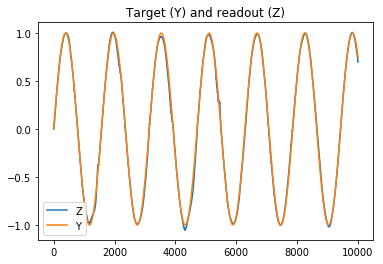

In [19]:
Y = y(force.taxis)
plt.plot(Z, label="Z")
plt.plot(Y, label="Y")
plt.title("Target (Y) and readout (Z)")
plt.legend()

<module 'matplotlib.pyplot' from '/Users/hkariti/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

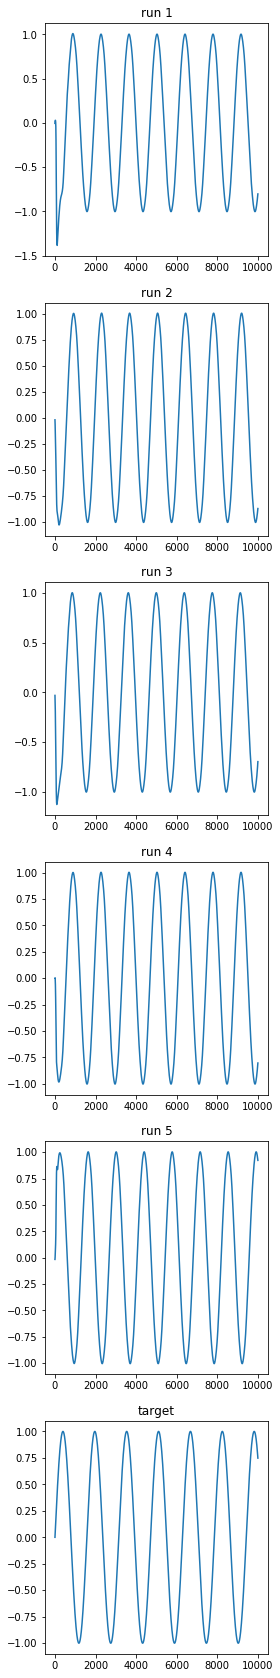

In [20]:
plot_test(force, Y)